# Symulacje

In [328]:
import random
from tqdm import tqdm

random.seed(123)

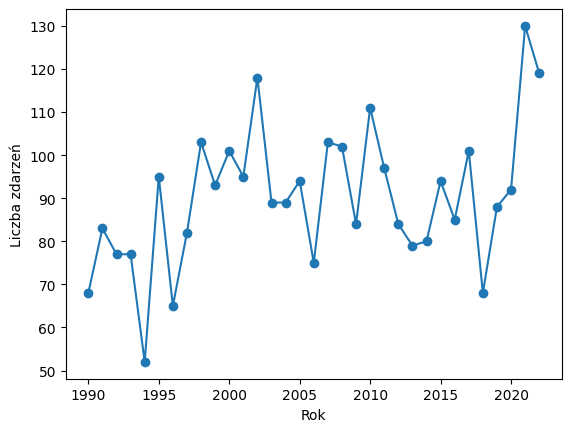

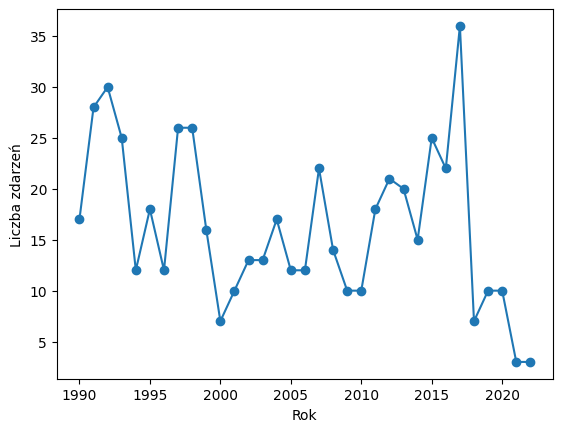

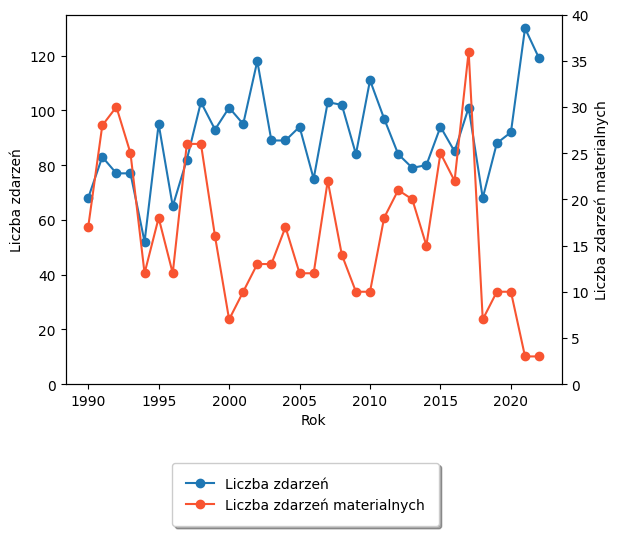

C:\Users\ndzadz001\AppData\Local\Temp\ipykernel_15124\2429601217.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


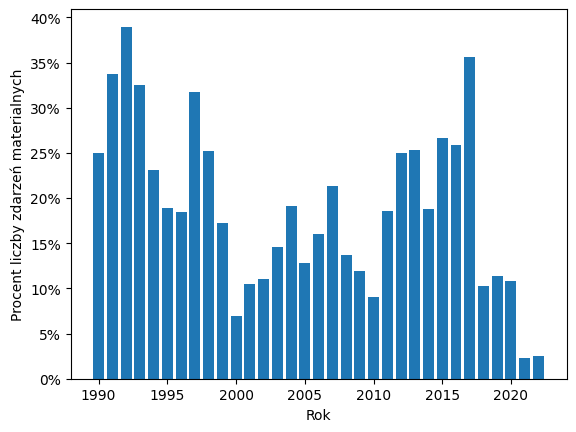

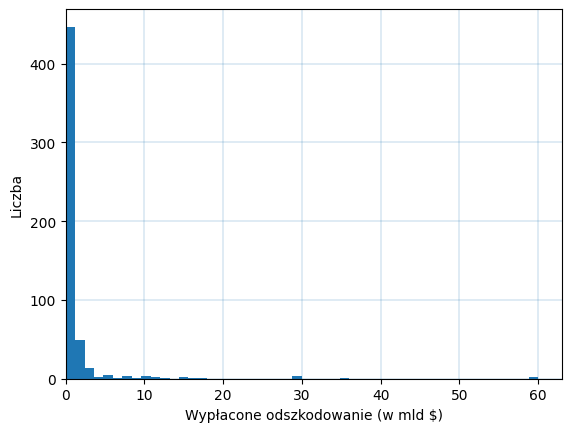

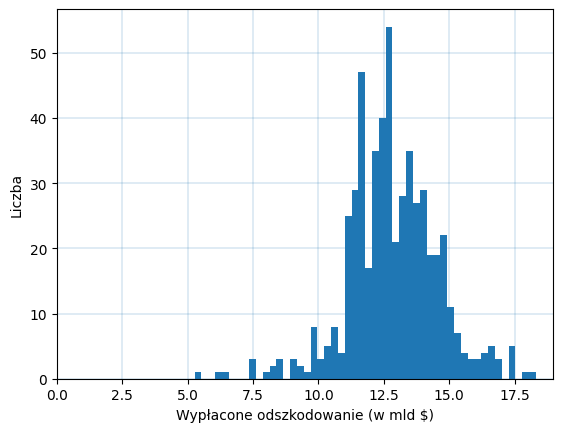

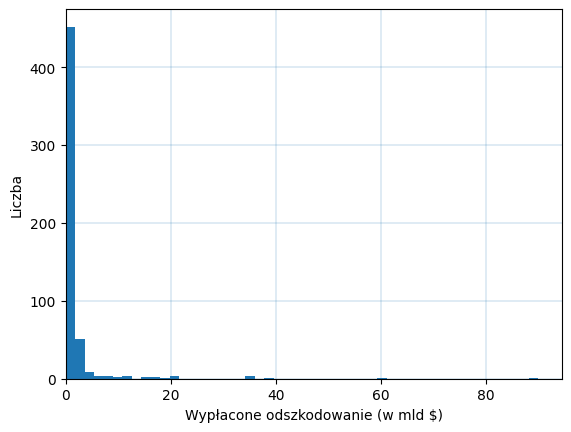

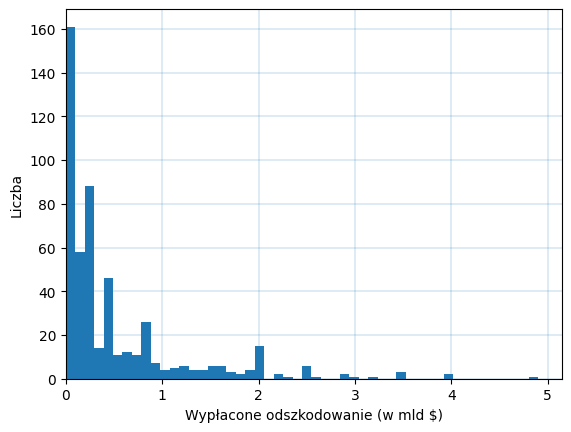

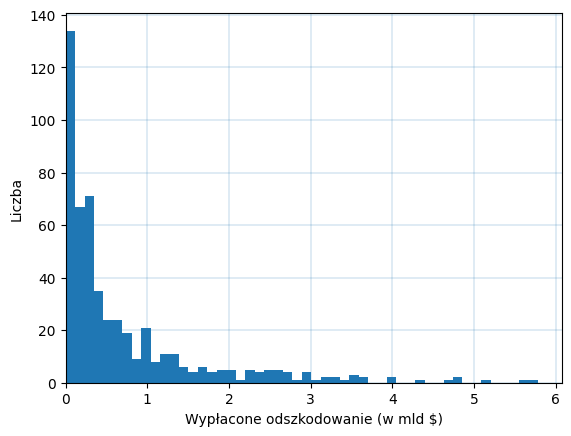

C:\Users\ndzadz001\AppData\Local\Temp\ipykernel_15124\2368923416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo['Number_of_days_in_year'] = np.where(data_wo['Year']%4==0, 366, 365)


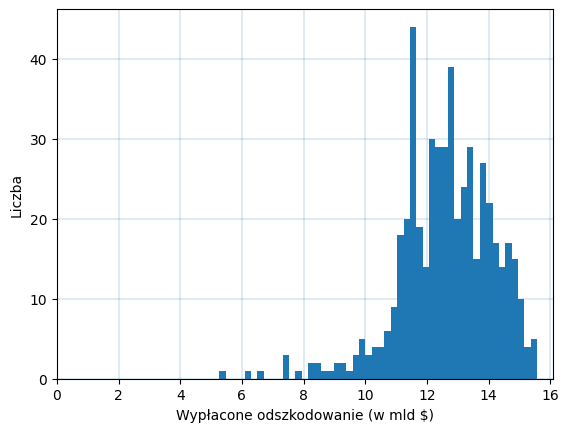

In [395]:
#%run "C:\Users\ndzadz001\Documents\Mgr\Repo\mgr\DataPreparation.ipynb"
#%run "C:\Users\ndzadz001\Documents\Mgr\Repo\mgr\Modelowanie_liczby_roszczen.ipynb"

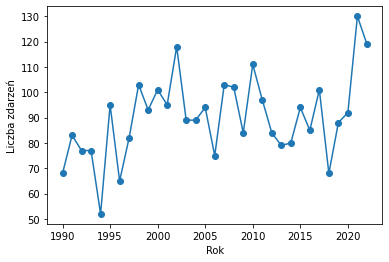

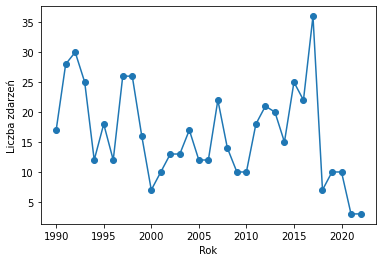

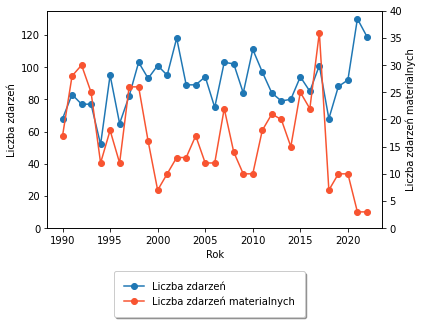

C:\Users\ndzad\AppData\Local\Temp/ipykernel_16244/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


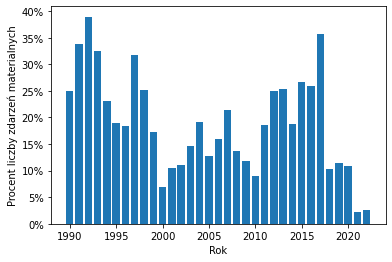

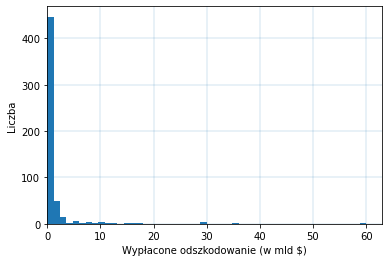

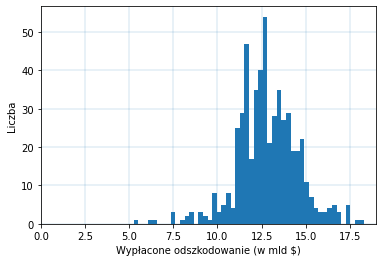

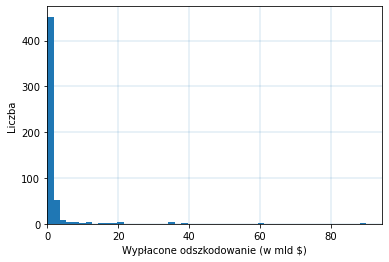

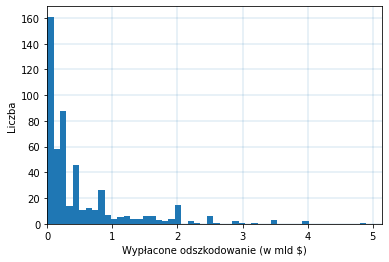

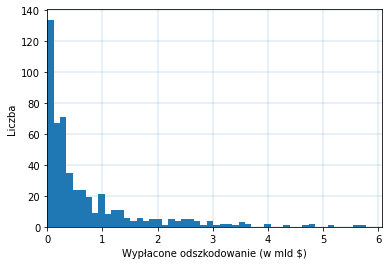

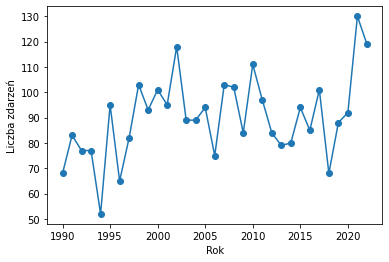

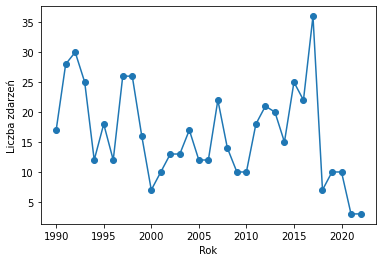

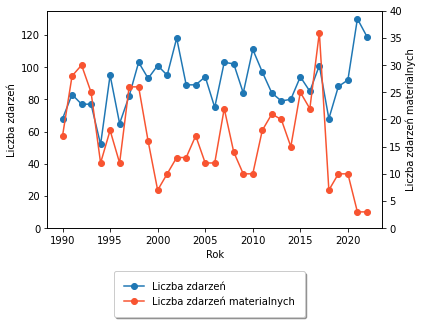

C:\Users\ndzad\AppData\Local\Temp/ipykernel_16244/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


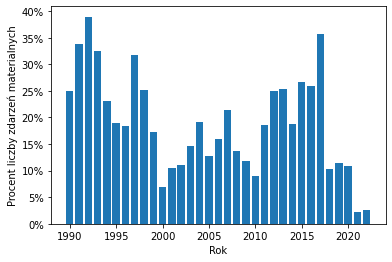

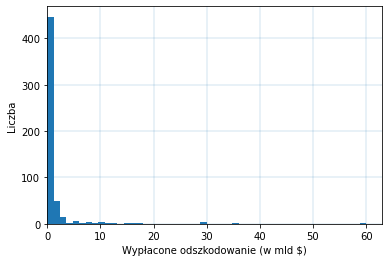

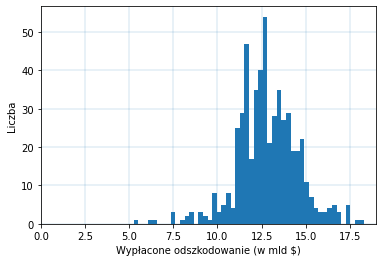

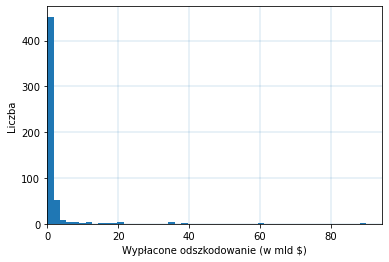

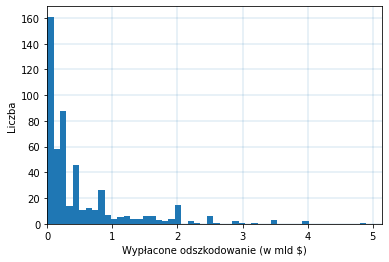

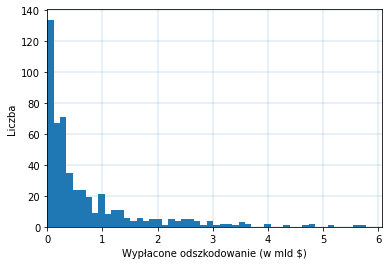

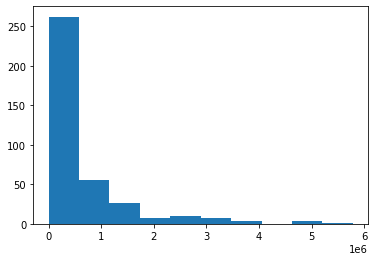

1.667e-06


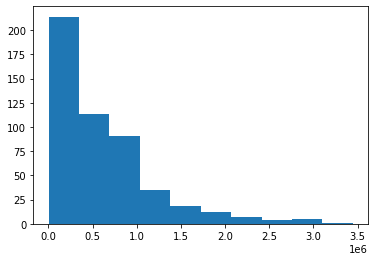

       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.24  1.006771e-18
1  Wykładniczy   CM                3.06  5.051111e-08
12.47 2.34
12.46672547764283 2.074318127197053


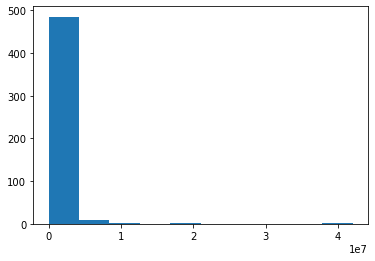

       rozkład test  Wartość statystyki   p value
0  Lognormalny   KS                0.06  0.106111
1  Lognormalny   CM                0.22  0.227369
0.72 1.1988586302925719e-06


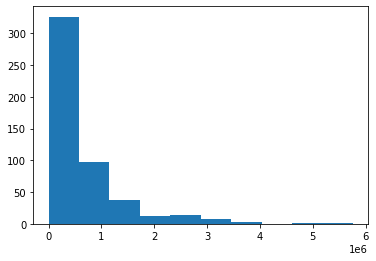

  rozkład test  Wartość statystyki   p value
0   Gamma   KS                0.13  0.000012
1   Gamma   CM                1.02  0.002138
0.786188921301622 514170.5554941683


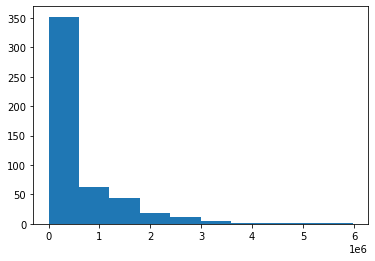

    rozkład test  Wartość statystyki   p value
0  Weibulla   KS                0.10  0.001004
1  Weibulla   CM                0.59  0.023748


c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1.861639368063435 0.043086409391061675
  rozkład test  Wartość statystyki       p value
0   Burra   KS                0.51  4.854888e-90
1   Burra   CM               29.38  4.346694e-09
       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08
2  Lognormalny   KS                0.06  1.061111e-01
3  Lognormalny   CM                0.22  2.273687e-01
4        Gamma   KS                0.13  1.164551e-05
5        Gamma   CM                1.02  2.137666e-03
6     Weibulla   KS                0.10  1.004223e-03
7     Weibulla   CM                0.59  2.374758e-02
8        Burra   KS                0.51  4.854888e-90
9        Burra   CM               29.38  4.346694e-09


In [329]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_liczby_roszczen.ipynb"
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_odszkodowan.ipynb"
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_ryzyka.ipynb"

## Symulacja liczby roszczeń

In [330]:
number_of_simulations = 500

### Empiryczna liczba roszczeń ze zbioru danych

In [331]:
T = pd.DataFrame({'t':[1990 + t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
for r in range(1991,2023):
    if r%4==0:
        T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    else:
        T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
T.reset_index(drop=True,inplace=True)

In [332]:
N = pd.merge(T, data_wo[['t','Ind']], on='t', how='left').fillna(0).groupby('t').sum().cumsum().assign(Year=np.floor(pd.merge(T, data_wo[['t','Ind']], on='t', how='left')['t']))
N = N.assign(Year=np.floor(N.index))
n = N.groupby('Year').max('Ind').diff().fillna(float(N.groupby('Year').max('Ind').head(1)['Ind'])).rename(columns = {'Ind':'n'})

T_train = T[T['t']<2013]
t_train = T_train['t'] - 1990
n_train = n[n.index<=2012]
N_train = N[N['Year']<=2012]

T_test = T[T['t']>=2013]
t_test = T_test['t'] - 2013
n_test = n[n.index>2012]
N_test = N[N['Year']>2012]

### Sinusoidalna funkcja intensywności

Dopasowanie

In [333]:
sin_params = scipy.optimize.curve_fit(cum_sin_int_fun, xdata = t_train, ydata = N_train["Ind"], method = 'lm')[0]

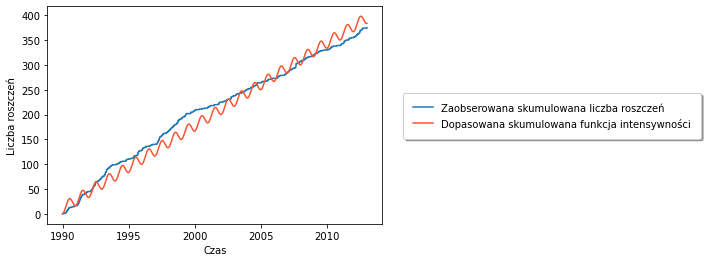

In [529]:
plt.plot(N_train['Ind'], linestyle= '-')
plt.plot(1990+t_train,cum_sin_int_fun(t_train,sin_params[0], sin_params[1], sin_params[2]), linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Dopasowana skumulowana funkcja intensywności'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.65,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\sin_N_cum_int_func.pdf",bbox_inches='tight')

plt.show()

Predykcja

In [335]:
N_sin = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))

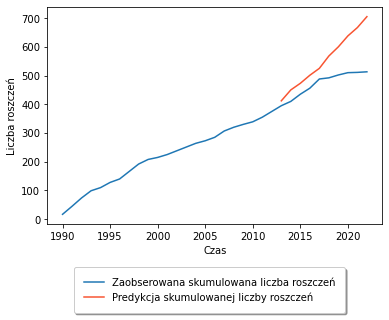

In [336]:
plt.plot(N.groupby('Year').max('Ind'), linestyle= '-')
plt.plot(range(2013,2023,1), N_sin[2] + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Predykcja skumulowanej liczby roszczeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\sin_number.pdf",bbox_inches='tight')

plt.show()

Dodać wizualizacje średniej i max/min lub percentyli

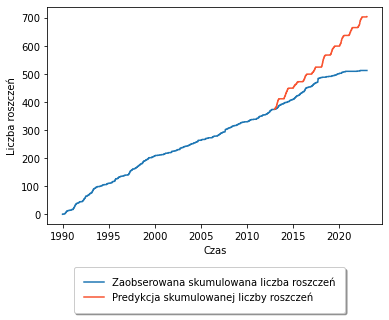

In [337]:
#Pojedyncza symulacja

plt.plot(N["Ind"], linestyle= '-')
plt.plot(nhpp_pred(t_test, N_sin[1], T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Predykcja skumulowanej liczby roszczeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\sin_number_cum.pdf",bbox_inches='tight')

plt.show()

In [338]:
N_sin_simulations = []

for i in range(number_of_simulations):
    N_sin_simulations.append(nhpp_pred(t_test, nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))[1], T_test['t']))

N_sin_avg = np.mean(N_sin_simulations,axis=0)
N_sin_5p = np.percentile(N_sin_simulations,5,axis=0)
N_sin_95p = np.percentile(N_sin_simulations,95,axis=0)

In [125]:
# sin_5p = np.percentile([N.tail(1) for N in N_sin_simulations],5)
# sin_95p = np.percentile([N.tail(1) for N in N_sin_simulations],95)
# sin_mean = np.mean([N.tail(1) for N in N_sin_simulations])

# sin_5p_index = next((i for i, row in enumerate(np.array(N_sin_simulations)) if row[-1] >= sin_5p), None)
# sin_95p_index = next((i for i, row in enumerate(np.array(N_sin_simulations)) if row[-1] >= sin_95p), None)
# sin_mean_index = next((i for i, row in enumerate(np.array(N_sin_simulations)) if row[-1] >= sin_mean), None)

# N_sin_5p = N_sin_simulations[sin_5p_index]
# N_sin_95p = N_sin_simulations[sin_95p_index]
# N_sin_mean = N_sin_simulations[sin_mean_index]

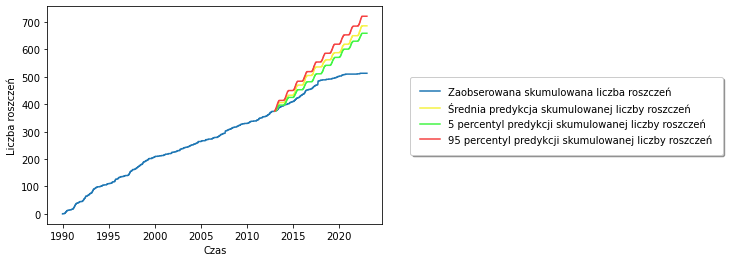

In [539]:
plt.plot(N["Ind"], linestyle= '-')
plt.plot(pd.DataFrame({"N" : N_sin_mean},index=T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f5f242")
plt.plot(pd.DataFrame({"N" : N_sin_5p},index=T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#42f545")
plt.plot(pd.DataFrame({"N" : N_sin_95p},index=T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f54242")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Średnia predykcja skumulowanej liczby roszczeń','5 percentyl predykcji skumulowanej liczby roszczeń','95 percentyl predykcji skumulowanej liczby roszczeń'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.7,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\sin_number_cum_avg.pdf",bbox_inches='tight')

plt.show()

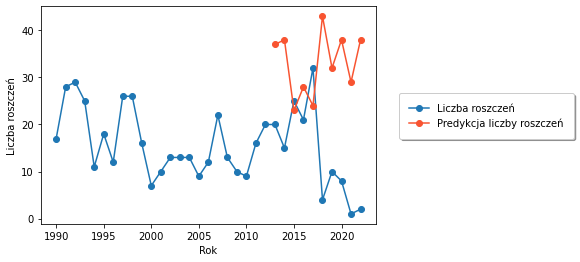

In [541]:
plt.plot(n, linestyle= '-', marker='o')
plt.plot(N_test["Year"].unique(),N_sin[2].diff().fillna(N_sin[2][0]), linestyle= '-',marker='o' ,color="#f85431")

plt.xlabel("Rok")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Liczba roszczeń','Predykcja liczby roszczeń'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.37,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\sin_number.pdf",bbox_inches='tight')

plt.show()

### Funkcja intensywności typu Power Law

Dopasowanie

In [341]:
power_law_params = scipy.optimize.curve_fit(cum_power_law_int_fun, xdata = t_train, ydata = N_train["Ind"], method = 'lm')[0]

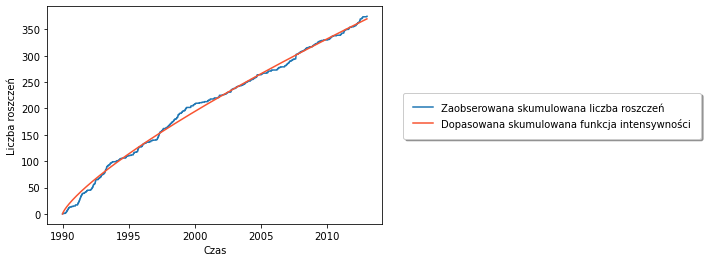

In [565]:
plt.plot(N_train['Ind'], linestyle= '-')
plt.plot(1990+t_train,cum_power_law_int_fun(t_train, power_law_params[0], power_law_params[1]), linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Dopasowana skumulowana funkcja intensywności'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.65,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\power_law_N_cum_int_func.pdf",bbox_inches='tight')

plt.show()

Predykcja

In [343]:
N_power_law = nhpp(power_law_int_fun, power_law_params, len(np.floor(T_test['t']).unique()))

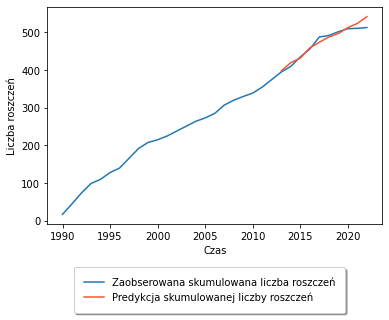

In [344]:
plt.plot(N.groupby('Year').max('Ind'), linestyle= '-')
plt.plot(range(2013,2023,1), N_power_law[2] + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Predykcja skumulowanej liczby roszczeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\power_law_number.pdf",bbox_inches='tight')

plt.show()

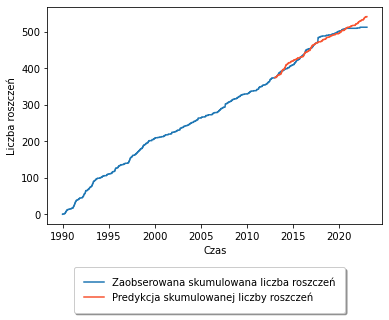

In [345]:
#Pojedyncza symulacja

plt.plot(N["Ind"], linestyle= '-')
plt.plot(nhpp_pred(t_test, N_power_law[1], T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Predykcja skumulowanej liczby roszczeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\power_law_number_cum.pdf",bbox_inches='tight')

plt.show()

In [346]:
N_power_law_simulations = []

for i in range(number_of_simulations):
    N_power_law_simulations.append(nhpp_pred(t_test, nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))[1], T_test['t']))

N_power_law_avg = np.mean(N_power_law_simulations,axis=0)
N_power_law_5p = np.percentile(N_power_law_simulations,5,axis=0)
N_power_law_95p = np.percentile(N_power_law_simulations,95,axis=0)

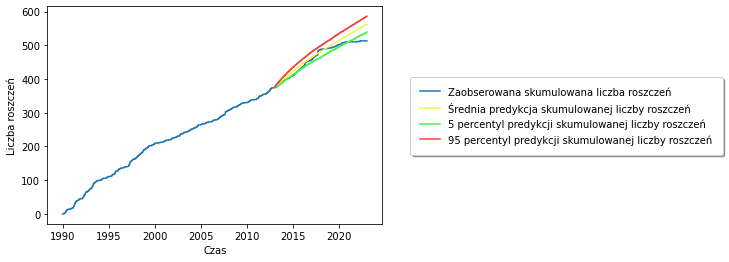

In [543]:
plt.plot(N["Ind"], linestyle= '-')
plt.plot(pd.DataFrame({"N" : N_power_law_avg},index=T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f5f242")
plt.plot(pd.DataFrame({"N" : N_power_law_5p},index=T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#42f545")
plt.plot(pd.DataFrame({"N" : N_power_law_95p},index=T_test['t']) + float(N_train.tail(1)['Ind']), linestyle= '-',color="#f54242")

plt.xlabel("Czas")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Zaobserowana skumulowana liczba roszczeń','Średnia predykcja skumulowanej liczby roszczeń','5 percentyl predykcji skumulowanej liczby roszczeń','95 percentyl predykcji skumulowanej liczby roszczeń'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.7,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\power_law_number_cum_avg.pdf",bbox_inches='tight')

plt.show()

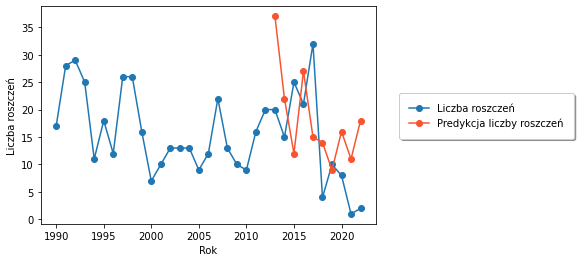

In [549]:
plt.plot(n, linestyle= '-', marker='o')
plt.plot(N_test["Year"].unique(),N_power_law[2].diff().fillna(N_sin[2][0]), linestyle= '-',marker='o' ,color="#f85431")

plt.xlabel("Rok")
plt.ylabel("Liczba roszczeń")
plt.figlegend(['Liczba roszczeń','Predykcja liczby roszczeń'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.37,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\power_law_number.pdf",bbox_inches='tight')

plt.show()

### Wyniki

In [349]:
MSE_sin_array = []
MAE_sin_array = []

for i in range(number_of_simulations):
    MSE_sin_array.append(MSE(N_test['Ind'].tail(1), (nhpp_pred(t_test, nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique())+1)[1], T_test['t'])+ float(N_train.tail(1)['Ind'])).tail(1)))
    MAE_sin_array.append(MAE(N_test['Ind'].tail(1), (nhpp_pred(t_test, nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique())+1)[1], T_test['t'])+ float(N_train.tail(1)['Ind'])).tail(1)))

MSE_sin = np.sum(MSE_sin_array)/number_of_simulations
MAE_sin = np.sum(MAE_sin_array)/number_of_simulations

In [350]:
MSE_power_law_array = []
MAE_power_law_array = []

for i in range(number_of_simulations):
    MSE_power_law_array.append(MSE(N_test['Ind'].tail(1), (nhpp_pred(t_test, nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique())+1)[1], T_test['t'])+ float(N_train.tail(1)['Ind'])).tail(1)))
    MAE_power_law_array.append(MAE(N_test['Ind'].tail(1), (nhpp_pred(t_test, nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique())+1)[1], T_test['t'])+ float(N_train.tail(1)['Ind'])).tail(1)))

MSE_power_law = np.sum(MSE_power_law_array)/number_of_simulations
MAE_power_law = np.sum(MAE_power_law_array)/number_of_simulations

In [351]:
print(pd.DataFrame
({
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'parametry':[sin_params.round(3),power_law_params.round(3)],
    'MSE':[round(np.mean(MSE_sin),2),round(np.mean(MSE_power_law),2)],
    'MAE':[round(np.mean(MAE_sin),2),round(np.mean(MAE_power_law),2)]                                            
}))

                       funkcja                parametry       MSE     MAE
0  Sinusoidalna funkcja straty  [16.688, 11.076, 1.004]  29978.79  173.51
1                    Power Law           [32.86, 0.772]   2602.38   48.15


## Symulacja wartości odszkodowań

### Dane zaobserwowane

In [352]:
loss_full = pd.merge(T, data_wo[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_full = loss_full.cumsum()

In [353]:
loss_train = pd.merge(T_train, train[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_train = loss_train.cumsum()

In [354]:
loss_test = pd.merge(T_test, test[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_test = loss_test.cumsum()

In [355]:
def loss_pred(t, n, damages, t_index):
    """
    Funkcja generuje proces dla zaobserwowanych zdarzeń.

    Argumenty:
        t: array
            Przestrzeń czasów
        n: array
            Zaobserowane czasy zdarzenia
        damages: array
            Straty
        t_index: array
            Pożądane indeksy
    Zwraca:
        pandas.Series
            Tablica czasów.
    """
    df = pd.DataFrame({'t':n, 'damages':damages}).set_index('t')
    counts = [sum([1 for x in n if x <= y]) for y in t]
    values = [sum([df['damages'][x] for x in n if x <= y]) for y in t]
    return(pd.DataFrame({'n' : counts, 'damages': values}, index = t_index))

### Rozkład wykładniczy

Sinusoidalna funkcja intensywności

In [23]:
damages_sin_exp = np.array([stats.expon.rvs(scale=1/exp_lambda,loc=0,size=1) for i in range(len(N_sin[1]))]).flatten()
cum_loss_sin_exp = loss_pred(t_test,N_sin[1],damages_sin_exp, T_test['t'])

In [356]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_exp_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_exp = np.sum(MSE_array)/number_of_simulations
MAE_sin_exp = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [55:35<00:00,  6.67s/it] 


Funkcja intensywności typu Power Law

In [137]:
damages_power_law_exp = np.array([stats.expon.rvs(scale=1/exp_lambda,loc=0,size=1) for i in range(len(N_power_law[1]))]).flatten()
cum_loss_power_law_exp = loss_pred(t_test,N_power_law[1],damages_power_law_exp, T_test['t'])

In [357]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_exp_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_exp = np.sum(MSE_array)/number_of_simulations
MAE_power_law_exp = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [28:01<00:00,  3.36s/it]


### Rozkład lognormalny

Sinusoidalna funkcja intensywności

In [25]:
damages_sin_ln = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq),scale=np.exp(ln_mu),size=1) for i in range(len(N_sin[1]))]).flatten()
cum_loss_sin_ln = loss_pred(t_test,N_sin[1],damages_sin_ln, T_test['t'])

In [358]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq),scale=np.exp(ln_mu),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_ln_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_ln = np.sum(MSE_array)/number_of_simulations
MAE_sin_ln = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [43:28<00:00,  5.22s/it]


Funkcja intensywności typu Power Law

In [26]:
damages_power_law_ln = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq),scale=np.exp(ln_mu),size=1) for i in range(len(N_power_law[1]))]).flatten()
cum_loss_power_law_ln = loss_pred(t_test,N_power_law[1],damages_power_law_ln, T_test['t'])

In [359]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq),scale=np.exp(ln_mu),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_ln_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_ln = np.sum(MSE_array)/number_of_simulations
MAE_power_law_ln = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [27:11<00:00,  3.26s/it]


### Rozkład gamma

Sinusoidalna funkcja intensywności

In [27]:
damages_sin_gamma = np.array([stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=1) for i in range(len(N_sin[1]))]).flatten()
cum_loss_sin_gamma = loss_pred(t_test,N_sin[1],damages_sin_gamma, T_test['t'])

In [360]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_gamma_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_gamma = np.sum(MSE_array)/number_of_simulations
MAE_sin_gamma = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [44:03<00:00,  5.29s/it]


Funkcja intensywności typu Power Law

In [28]:
damages_power_law_exp = np.array([stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=1) for i in range(len(N_power_law[1]))]).flatten()
cum_loss_power_law_gamma = loss_pred(t_test,N_power_law[1],damages_power_law_exp, T_test['t'])

In [361]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_gamma_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_gamma = np.sum(MSE_array)/number_of_simulations
MAE_power_law_gamma = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [27:33<00:00,  3.31s/it]


### Rozkład Weibulla

Sinusoidalna funkcja intensywności

In [29]:
damages_sin_weibull = np.array([stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=1) for i in range(len(N_sin[1]))]).flatten()
cum_loss_sin_weibull = loss_pred(t_test,N_sin[1],damages_sin_weibull, T_test['t'])

In [362]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_weibull_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_weibull = np.sum(MSE_array)/number_of_simulations
MAE_sin_weibull = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [45:44<00:00,  5.49s/it]


Funkcja intensywności typu Power Law

In [30]:
damages_power_law_weibull = np.array([stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=1) for i in range(len(N_power_law[1]))]).flatten()
cum_loss_power_law_weibull = loss_pred(t_test,N_power_law[1],damages_power_law_weibull, T_test['t'])

In [363]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_weibull_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_weibull = np.sum(MSE_array)/number_of_simulations
MAE_power_law_weibull = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [28:17<00:00,  3.40s/it]


### Rozkad Burra

Sinusoidalna funkcja intensywności

In [31]:
damages_sin_burr = np.array([stats.burr12.rvs(c=burr_c,d=burr_k,size=1) for i in range(len(N_sin[1]))]).flatten()
cum_loss_sin_burr = loss_pred(t_test,N_sin[1],damages_sin_burr, T_test['t'])

In [364]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c,d=burr_k,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_burr_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_burr = np.sum(MSE_array)/number_of_simulations
MAE_sin_burr = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [41:25<00:00,  4.97s/it]


Funkcja intensywności typu Power Law

In [32]:
damages_power_law_burr = np.array([stats.burr12.rvs(c=burr_c,d=burr_k,size=1) for i in range(len(N_power_law[1]))]).flatten()
cum_loss_power_law_burr = loss_pred(t_test,N_power_law[1],damages_power_law_burr, T_test['t'])

In [365]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c,d=burr_k,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_burr_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_burr = np.sum(MSE_array)/number_of_simulations
MAE_power_law_burr = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [27:37<00:00,  3.31s/it]


## Symulacja strat

### Rozkład wykładniczy

Sinusoidalna funkcja intensywności

NameError: name 'cum_loss_sin_exp' is not defined

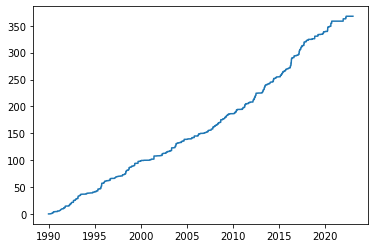

In [550]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_sin_exp["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.65,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_sin.pdf",bbox_inches='tight')
plt.show()

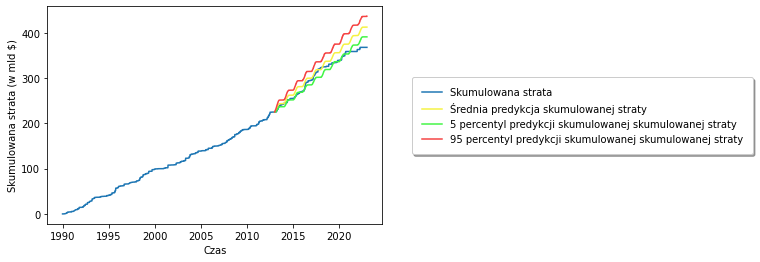

In [554]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_exp_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_exp_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_exp_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_sin_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

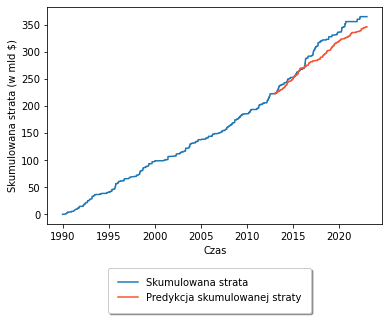

In [34]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_power_law_exp["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_power_law.pdf",bbox_inches='tight')
plt.show()

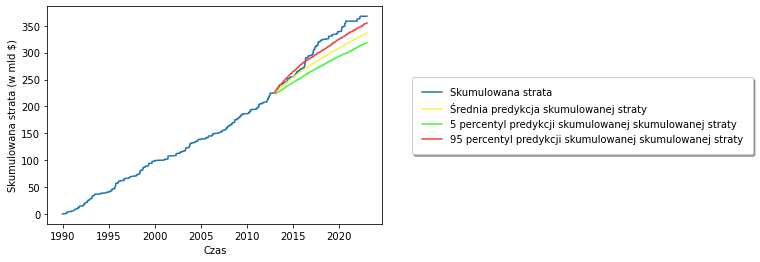

In [555]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_exp_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_exp_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_exp_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_power_law_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład lognormalny

Sinusoidalna funkcja intensywności

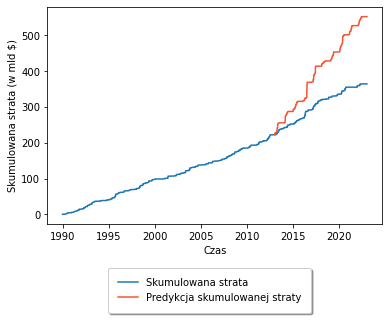

In [42]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_sin_ln["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_ln_sin.pdf",bbox_inches='tight')
plt.show()

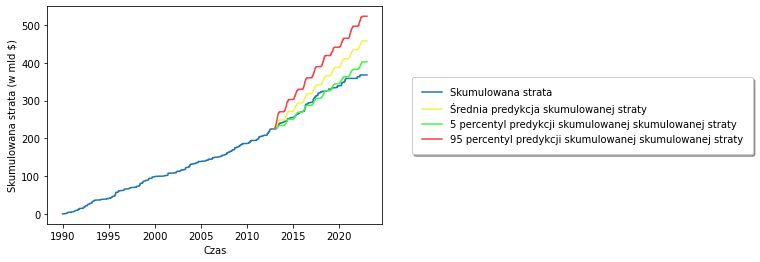

In [556]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_ln_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_ln_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_ln_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_ln_sin_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

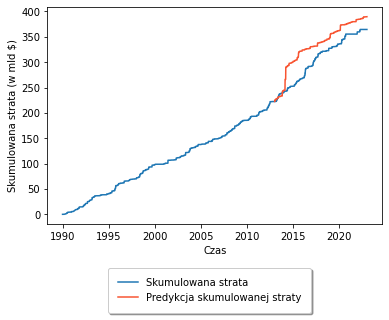

In [36]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_power_law_ln["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_ln_power_law.pdf",bbox_inches='tight')
plt.show()

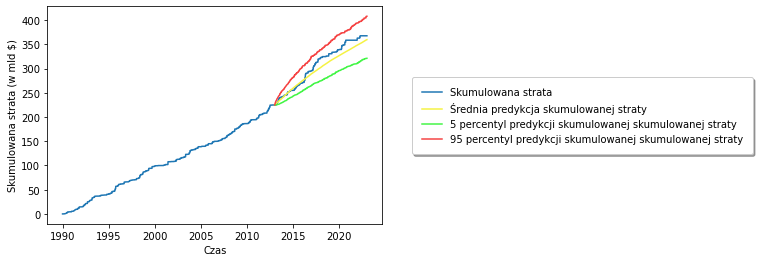

In [557]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_ln_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_ln_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_ln_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_ln_power_law_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład gamma

Sinusoidalna funkcja intensywności

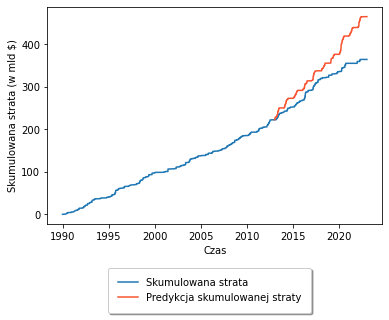

In [37]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_sin_gamma["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_gamma_sin.pdf",bbox_inches='tight')
plt.show()

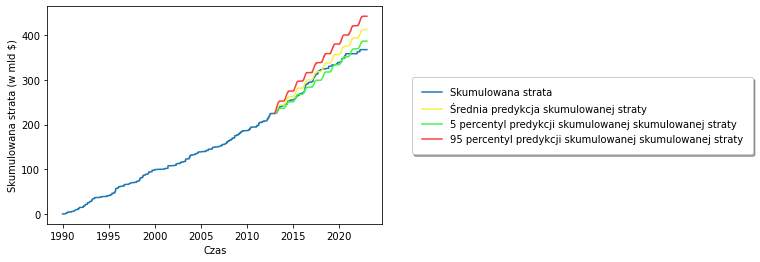

In [558]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_gamma_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_gamma_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_gamma_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_gamma_sin_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

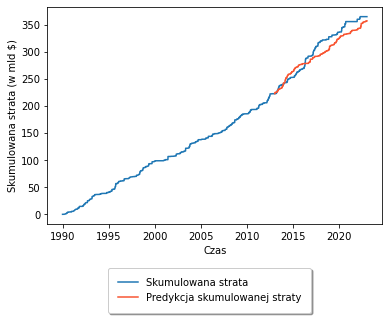

In [38]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_power_law_gamma["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_gamma_power_law.pdf",bbox_inches='tight')
plt.show()

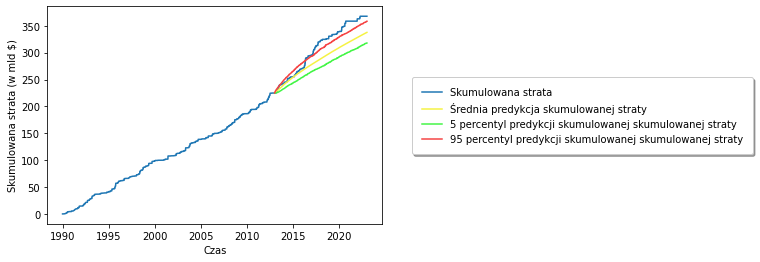

In [559]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_gamma_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_gamma_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_gamma_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_gamma_power_law_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Weibulla

Sinusoidalna funkcja intensywności

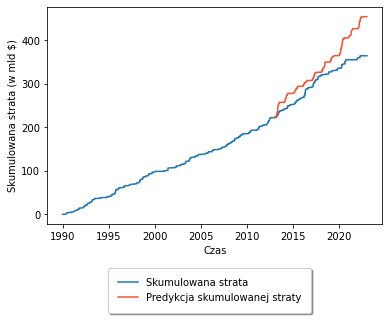

In [39]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_sin_weibull["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_weibull_sin.pdf",bbox_inches='tight')
plt.show()

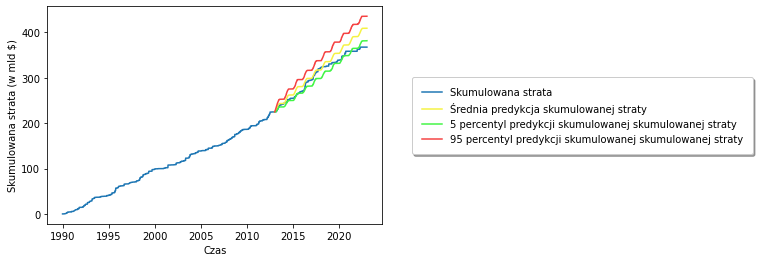

In [560]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_weibull_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_weibull_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_weibull_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_weibull_sin_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

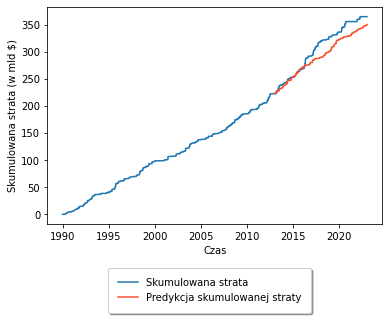

In [41]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_power_law_weibull["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_weibull_power_law.pdf",bbox_inches='tight')
plt.show()

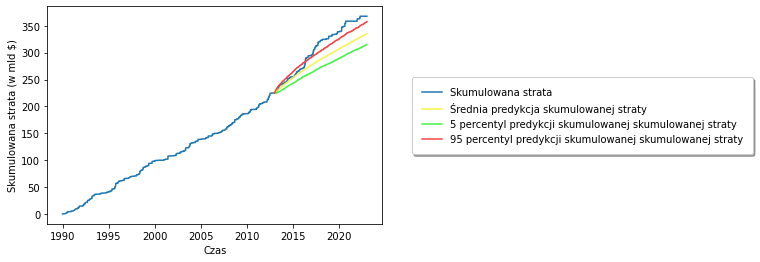

In [561]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_weibull_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_weibull_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_weibull_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_weibull_power_law_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Burra

Sinusoidalna funkcja intensywności

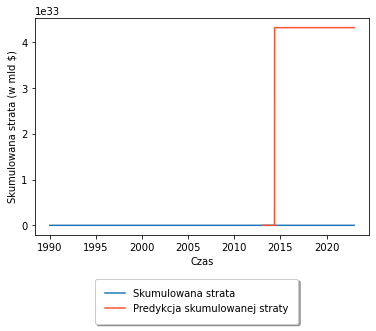

In [225]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_sin_burr["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_burr_sin.pdf",bbox_inches='tight')
plt.show()

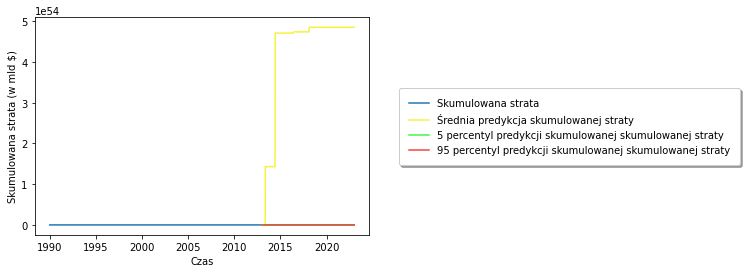

In [562]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_burr_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_burr_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_burr_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_burr_sin_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

NameError: name 'cum_loss_power_law_burr' is not defined

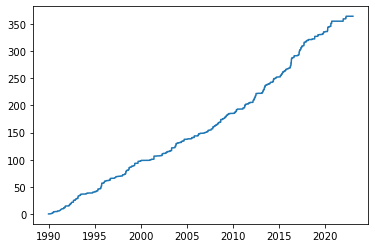

In [203]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_loss_power_law_burr["damages"]+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))

#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_burr_power_law.pdf",bbox_inches='tight')
plt.show()

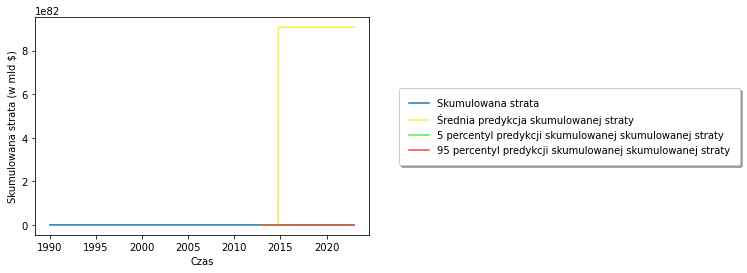

In [563]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_burr_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_burr_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_burr_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_burr_power_law_avg.pdf",bbox_inches='tight')
plt.show()

### Wyniki

In [378]:
# Wyniki

print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':["{:e}".format(MSE_sin_exp),"{:e}".format(MSE_power_law_exp),"{:e}".format(MSE_sin_ln),"{:e}".format(MSE_power_law_ln),"{:e}".format(MSE_sin_gamma),"{:e}".format(MSE_power_law_gamma),"{:e}".format(MSE_sin_weibull),"{:e}".format(MSE_power_law_weibull),"{:e}".format(MSE_sin_burr),"{:e}".format(MSE_power_law_burr)],
    'MAE':["{:e}".format(MAE_sin_exp),"{:e}".format(MAE_power_law_exp),"{:e}".format(MAE_sin_ln),"{:e}".format(MAE_power_law_ln),"{:e}".format(MAE_sin_gamma),"{:e}".format(MAE_power_law_gamma),"{:e}".format(MAE_sin_weibull),"{:e}".format(MAE_power_law_weibull),"{:e}".format(MAE_sin_burr),"{:e}".format(MAE_power_law_burr)]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.288079e+16  2.696044e+08
1  Wykładniczy     Power Law   3.767024e+16  1.937507e+08
2  Lognormalny  Sinusoidalna   1.007799e+17  3.150707e+08
3  Lognormalny     Power Law   4.781760e+16  2.169299e+08
4        Gamma  Sinusoidalna   7.310069e+16  2.698252e+08
5        Gamma     Power Law   3.813317e+16  1.948465e+08
6     Weibulla  Sinusoidalna   7.133807e+16  2.665312e+08
7     Weibulla     Power Law   3.721415e+16  1.924658e+08
8        Burra  Sinusoidalna  6.409370e+123  4.854899e+60
9        Burra     Power Law  4.113273e+180  9.070031e+88


In [388]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':[MSE_sin_exp,MSE_power_law_exp,MSE_sin_ln,MSE_power_law_ln,MSE_sin_gamma,MSE_power_law_gamma,MSE_sin_weibull,MSE_power_law_weibull,MSE_sin_burr,MSE_power_law_burr],
    'MAE':[MAE_sin_exp,MAE_power_law_exp,MAE_sin_ln,MAE_power_law_ln,MAE_sin_gamma,MAE_power_law_gamma,MAE_sin_weibull,MAE_power_law_weibull,MAE_sin_burr,MAE_power_law_burr]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.288079e+16  2.696044e+08
1  Wykładniczy     Power Law   3.767024e+16  1.937507e+08
2  Lognormalny  Sinusoidalna   1.007799e+17  3.150707e+08
3  Lognormalny     Power Law   4.781760e+16  2.169299e+08
4        Gamma  Sinusoidalna   7.310069e+16  2.698252e+08
5        Gamma     Power Law   3.813317e+16  1.948465e+08
6     Weibulla  Sinusoidalna   7.133807e+16  2.665312e+08
7     Weibulla     Power Law   3.721415e+16  1.924658e+08
8        Burra  Sinusoidalna  6.409370e+123  4.854899e+60
9        Burra     Power Law  4.113273e+180  9.070031e+88


## Proces ryzyka

In [481]:
rp_number_of_simulations = 1000

In [477]:
def ruin_prob(u, theta, mu, lambda_func, lambda_func_params, loss_distribution, t_max, n):
    """
    Funkcja generuje niejednorodny proces Poissona metodą przerzerzedzania.

    Argumenty:
        u: float
            Kapitał początkowy
        theta: float
            Narzut
        mu: float
            Wartość oczekiwana X
        lambda_func: funkcja
            Funkcja intensywności
        loss_distribution: string
            Rozkład strat
        t_max: float
            Maksymalny czas symulacji
        n: int
            Liczba symulacji
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka
    """
    negative = 0
    cum_losses = []
    MSE_array = []
    MAE_array = []
    I = integrate.quad(lambda x: lambda_func(x,lambda_func_params)[0],0, t_max)[0]
    C=(1+theta)*mu*I

    T = pd.DataFrame({'t':[t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
    for r in range(1,t_max):
        if r%4==0:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
        else:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    T.reset_index(drop=True,inplace=True)

    for i in tqdm(range(n)):
        N_loss = nhpp(lambda_func,lambda_func_params,len(np.floor(T['t']).unique()))

        if loss_distribution == "expon":
            damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "lognormal":
            damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq),scale=np.exp(ln_mu),size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "gamma":
            damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "weibull":
            damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "burr":
            damages_loss = np.array([stats.burr12.rvs(c=burr_c,d=burr_k,size=1) for i in range(len(N_loss[1]))]).flatten()

        damages_loss_cum = loss_pred(T['t'],N_loss[1],damages_loss, T['t'])['damages']

        R = u + C - damages_loss_cum
        if np.sum(R<0) > 0:
            negative += 1

    return(negative/n)

### Funkcja intensywności typu Power Law

In [482]:
rp_5_expon_power_law = ruin_prob(1e7,0.3,1/exp_lambda,power_law_int_fun,power_law_params,"expon",5,rp_number_of_simulations)
rp_10_expon_power_law = ruin_prob(1e7,0.3,1/exp_lambda,power_law_int_fun,power_law_params,"expon",10,rp_number_of_simulations)
rp_15_expon_power_law = ruin_prob(1e7,0.3,1/exp_lambda,power_law_int_fun,power_law_params,"expon",15,rp_number_of_simulations)
rp_20_expon_power_law = ruin_prob(1e7,0.3,1/exp_lambda,power_law_int_fun,power_law_params,"expon",20,rp_number_of_simulations)
rp_50_expon_power_law = ruin_prob(1e7,0.3,1/exp_lambda,power_law_int_fun,power_law_params,"expon",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:07:41<00:00, 61.66s/it] 


In [483]:
rp_5_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,power_law_params,"gamma",5,rp_number_of_simulations)
rp_10_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,power_law_params,"gamma",10,rp_number_of_simulations)
rp_15_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,power_law_params,"gamma",15,rp_number_of_simulations)
rp_20_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,power_law_params,"gamma",20,rp_number_of_simulations)
rp_50_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,power_law_params,"gamma",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:24:11<00:00, 62.65s/it]  


In [484]:
rp_5_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,power_law_params,"weibull",5,rp_number_of_simulations)
rp_10_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,power_law_params,"weibull",10,rp_number_of_simulations)
rp_15_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,power_law_params,"weibull",15,rp_number_of_simulations)
rp_20_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,power_law_params,"weibull",20,rp_number_of_simulations)
rp_50_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,power_law_params,"weibull",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [18:42:02<00:00, 67.32s/it]   


In [485]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy',"Gamma","Weibulla"],
    'funkcja':['Power Law','Power Law','Power Law'],
    '5 lat':[rp_5_expon_power_law,rp_5_gamma_power_law,rp_5_weibull_power_law],
    '10 lat':[rp_10_expon_power_law,rp_10_gamma_power_law,rp_10_weibull_power_law],
    '15 lat':[rp_15_expon_power_law,rp_15_gamma_power_law,rp_15_weibull_power_law],
    '20 lat':[rp_20_expon_power_law,rp_20_gamma_power_law,rp_20_weibull_power_law],
    '50 lat':[rp_50_expon_power_law,rp_50_gamma_power_law,rp_50_weibull_power_law],
}))

       rozkład    funkcja  5 lat  10 lat  15 lat  20 lat  50 lat
0  Wykładniczy  Power Law  0.000   0.000     0.0     0.0     0.0
1        Gamma  Power Law  0.000   0.000     0.0     0.0     0.0
2     Weibulla  Power Law  0.001   0.002     0.0     0.0     0.0
